In [1]:
# TODO: Optimize MCMC code to run faster using parallelization or multithreading
# TODO: Add detailed docstrings to all functions and classes for better code documentation
# TODO: Implement unit tests
# TODO: Add more flexible parameter grid options for the models
# TODO: Investigate old code to understand why Spearman's rho used to be higher and orders were closer to the ideal order

import sys
import os

# set the path to the parent directory of 'simulation_class'
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
from simulation_class.canonical_generator import CanonicalGenerator
from simulation_class.sample_generator import SampleGenerator
from simulation_class.disease_progression_analyzer import DiseaseProgressionAnalyzer
from simulation_class.EBMAnalyzer import EBMAnalyzer

## SIGMOID demo

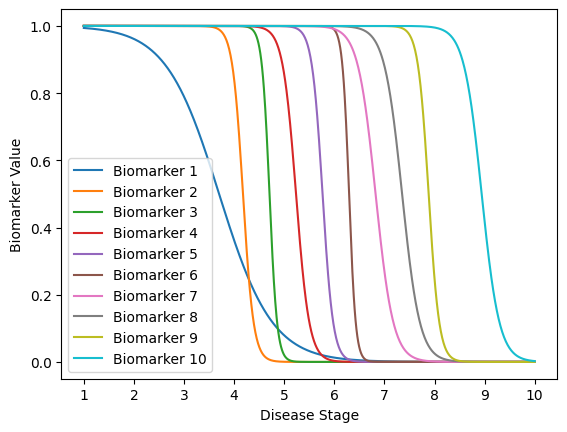

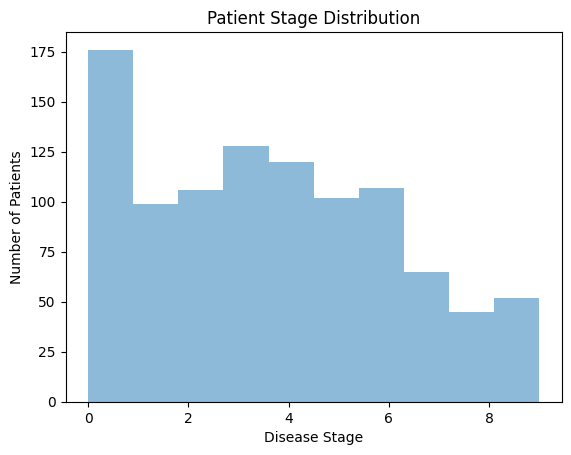

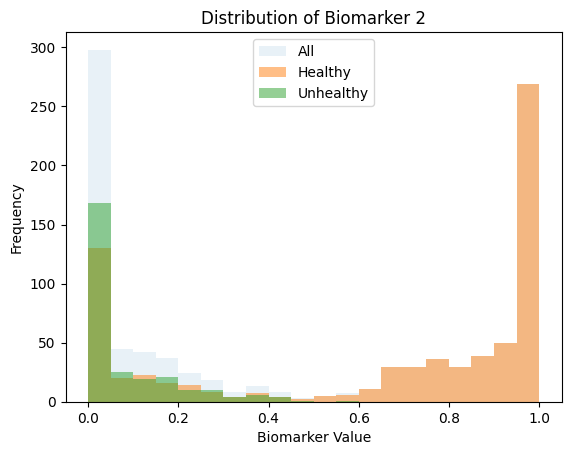

In [2]:
# model parameters
n_stages = 10
model_type = 'sigmoid'
biomarkers_params_sigmoid = {
    0: {'s': 0.1, 'c': 1.0},
    1: {'s': 0.5, 'c': 10.0},
    2: {'s': 0.7, 'c': 20.0},
    3: {'s': 0.4, 'c': 30.0},
    4: {'s': 0.5, 'c': 40.0},
    5: {'s': 0.8, 'c': 50.0},
    6: {'s': 0.3, 'c': 60.0},
    7: {'s': 0.3, 'c': 70.0},
    8: {'s': 0.5, 'c': 80.0},
    9: {'s': 0.3, 'c': 90.0},
    9: {'s': 0.3, 'c': 100.0},
}

# generate the canonical model
sigmoid_model = CanonicalGenerator(n_stages, model_type, biomarkers_params=biomarkers_params_sigmoid)
sigmoid_values = sigmoid_model.get_stage_values()

# plot disease progression
sigmoid_model.plot_disease_progression()

# generate patient samples
n_patients = 1000   
sample_generator = SampleGenerator(sigmoid_values,
                                   n_patients,
                                   dist_params={'loc': 3.5, 'scale': 3},
                                   add_noise=True,
                                   noise_std=0.2,
                                   random_state=2)

patient_samples = sample_generator.get_sample

# plot stage histogram
sample_generator.plot_stage_histogram()
sample_generator.plot_biomarker_distribution(biomarker_index=1, healthy_stage_threshold=0.5)

## Important EBM definitions.

$X$ is the dataset that contains $j$ patients and $i$ biomarker values generated at a particular stage. This contains no stage information.

$y$ is a vector that contains the binary labels for healthy and unhealthy, which is defined depending on patient stage, threshold.

Each patient is a vector of biomarker values, we are trying to find some order in the set of $S$, that correctly orders every event in the set of $E$.

The cardinality of $E$ is equal to the number of biomarkers measured for each patient, $\{E_1, ..., E_N\}$, i.e  $\{1,2,3\}$ if there are three biomarkers. In disease progression E_i will correspond to change in a biomarker going from healthy --> abnormal, once it goes above some arbitrary threshold (i.e. the corresponding stage and biomarker value)

$S$ is some **specific order** of all $E$, S can be many possible orders depending on $E$ which is $|E|!$.

If there are three biomarkers then: $S = \{(1,2,3),(1,3,2),(2,1,3),...,(3,2,1)\}$

Two assumptions outlined in Fonteijn et al. (2012):
1. **biomarkers monotonically decrease** once a biomarker changes due to disease progression, it cannot revert to a healthier state. 
2. The order of biomarker changes (events) is consistent across all patients, allowing data from different individuals to inform a common disease progression sequence.

*these are assumptions laid out in his paper which we intend to remove

In [3]:
# run analysis
X = sample_generator.get_sample()[0]
y = sample_generator.get_sample()[1]

print(X.shape)
print(y.shape)

(1000, 10)
(1000,)


##
The ultimate goal is to find some S that maximizes the posterior probability: $$p(S|X)$$ Which is say we want to find the most likely $S$ given our data $X$. To do that we start by fitting simples models for the likelihood function. In simple terms we are determining how probable the observed data is.

- $p(x_{ij}|E_i)$: is the probability (or likelihood) that a specific biomarker measurement $x_ij$ for patient j is observed, given that the event $E_i$ already happened. This tells us how the biomarker behaves if it’s affected by disease.

- $p(x_{ij}| \neg E_i)$: is the likelihood of observing the same biomarker value $x_{ij}$, given that biomarker is still healthy.

Using this we can compute the likelihood of observing $p(x_{1j}|E_1)$, $p(x_{2j}|E_2)$,..., $p(x_{Nj}|E_N)$ and for the negation as well, to evaluate whether some biomarker value is likely given that an event has occured or not. Using this we can compute the probability of observing a patient $X_j$ given they are at stage $k$ of $S$. This is given by Fonteijn's equation **(1)**.

$$p(X_j|S,k) = \prod_{i=1}^{k} p(x_{ij}|E_{s(i)}) \prod_{i=1}^{k} p(x_{ij}|\neg E_{s(i)})$$

But we want to deal in log probabilities therefore, 

$$p(X_j|S,k) = \sum_{i=1}^{k} \log p(x_{ij}|E_{s(i)}) + \sum_{i=1}^{k} \log p(x_{ij}|\neg E_{s(i)})$$

What this is saying is that all events in $S$ up and including $k$ have occured, multiply by the events that havent. Is this just a massive joint probability? 


In [4]:
def fit_distributions(X, y, normalize=False):
    """Fit distribution p(x|E), p(x|~E) as a mixture of Gaussian and Uniform, see Fonteijn 
    section `Mixture models for the data likelihood`.  p(x|E)
    - P(x|E) = P(x > X | E)
    - P(x|~E) = P(x < X| ~E)
    """
    # TODO: not sure about how to compute probabilities
    from scipy.stats import norm, uniform
    if normalize:
        X = X / X.max(axis=1)[:, np.newaxis]
    
    # compute avg and std. for control group (y=0)
    avg = X[y==0, ...].mean(axis=0)
    std = X[y==0, ...].std(axis=0)
    
    # fit gaussian for non-event healthy group
    p_not_e = [norm(loc, s) for loc, s in zip(avg, std)]

    # get min and max for event group (y=1)
    # left_min = X[y==1, ...].min(axis=0)
    left_min = X.min(axis=0)
    right_max = X[y==1, ...].max(axis=0) # avg.copy()
    
    ## why arent we using # avg.copy()? paper says to  use the mean of the healthy group as the upper bound for p(x|E) 
    
    p_e = [uniform(m1, m2-m1) for m1, m2 in zip(left_min, right_max)]
    return p_e, p_not_e, left_min, right_max #, avg, std


def compute_log_probabilities(X, p_e, p_not_e):
    """Compute the log-probabilities for each biomarker value in X."""
    J, N = X.shape  # J is number of patients, N is number of biomarkers

    log_p_e = np.zeros((J, N))
    log_p_not_e = np.zeros((J, N))

    # loop over each patient (j) and each biomarker (i)
    for j in range(J):
        for i in range(N):
            # log-probability that biomarker i for patient j follows p(x | E)
            log_p_e[j, i] = p_e[i].logpdf(X[j, i])

            # log-probability that biomarker i for patient j follows p(x | ~E)
            log_p_not_e[j, i] = p_not_e[i].logpdf(X[j, i])

    return log_p_e, log_p_not_e

### Equation 1 Fonteijn (2012)

def log_likelihood_patient(X_j, S, log_p_e, log_p_not_e, k, j):
    """Compute log-likelihood of patient j's data given event ordering S and stage k."""
    N = len(S)

    # sum the log-probabilities for the first k events (not healthy)
    log_likelihood = np.sum([log_p_e[j, S[i]] for i in range(k)])

    # sum the log-probabilities for the remaining N-k events (healthy)
    log_likelihood += np.sum([log_p_not_e[j, S[i]] for i in range(k, N)])

    return log_likelihood

Fonteijn does then integrate the k stage term out giving us equation **(2)** which is the likelyhood of observing a patient given S, $p(k)$ is the prior probability of being at position k.
$$p(X_j|S) = \sum_{k=0}^{N}{p(k)p(X_j|S,k)}$$

In [5]:
## Equation 2 Fonteijn (2012)
def integrate_over_k(X_j, S, log_p_e, log_p_not_e, j):
    """Integrate over all possible k values to compute the likelihood p(X_j | S)."""
    N = len(S)  # n_biomarkers
    log_likelihoods = np.zeros(N + 1)  # i want to store loglikes

    # for each stage k
    for k in range(N + 1):
        log_likelihoods[k] = log_likelihood_patient(X_j, S, log_p_e, log_p_not_e, k, j)
    likelihoods = np.exp(log_likelihoods) # go back to regular probability space
    total_likelihood = np.sum(likelihoods) / (N + 1)  # Uniform prior for p(k)

    return total_likelihood

def total_likelihood(X, S, log_p_e, log_p_not_e):
    """Compute the total likelihood p(X | S) over all patients."""
    J = X.shape[0]  # n_patients
    total_log_likelihood = 0

    # for every patient
    for j in range(J):
        # compute the log-probability for patient j
        p_X_j_given_S = integrate_over_k(X[j], S, log_p_e, log_p_not_e, j)
        total_log_likelihood += np.log(p_X_j_given_S)

    return total_log_likelihood

## MCMC - metropolis hastings algo

https://exowanderer.medium.com/metropolis-hastings-mcmc-from-scratch-in-python-c21e53c485b7

https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/MetropolisHastings

https://pymcmcstat.readthedocs.io/en/latest/

In [17]:
import emcee
import numpy as np

# swap two elements in a permutation
def propose_discrete_move(random, coords):
    new_coords = coords.copy()
    for walker in range(coords.shape[0]):
        i, j = random.choice(coords.shape[1], 2, replace=False)
        new_coords[walker, i], new_coords[walker, j] = new_coords[walker, j], new_coords[walker, i]
    return new_coords, np.zeros(coords.shape[0])

def log_prob(S, X, log_p_e, log_p_not_e):
    S = np.argsort(S)
    return total_likelihood(X, S, log_p_e, log_p_not_e)

X = sample_generator.get_sample()[0]
y = sample_generator.get_sample()[1]

n_biomarkers = X.shape[1]
n_steps = 100
n_walkers = n_biomarkers * 4  # number of walkers (should be at least 2x n_biomarkers)

p_e, p_not_e, left_min, right_max = fit_distributions(X, y)
log_p_e, log_p_not_e = compute_log_probabilities(X, p_e, p_not_e)
initial_state = np.array([np.random.permutation(n_biomarkers) for _ in range(n_walkers)])

mh_move = emcee.moves.MHMove(propose_discrete_move)
sampler = emcee.EnsembleSampler(n_walkers, n_biomarkers, log_prob, args=(X, log_p_e, log_p_not_e), moves=[mh_move])
sampler.run_mcmc(initial_state, n_steps)
samples = sampler.get_chain()
print(samples)


ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

In [7]:
import sys
import os

# set the path to the parent directory of 'simulation_class'
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
from simulation_class.ebm import mcmc, get_optimal_order

p_e, p_not_e, left_min, right_max = fit_distributions(X, y)
log_p_e, log_p_not_e = compute_log_probabilities(X, p_e, p_not_e)

orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e, n_iter=100_000, random_state=10)

100%|██████████| 100000/100000 [00:28<00:00, 3510.14it/s]


In [18]:
print(np.shape(orders))

order_map, best_order = get_optimal_order(list(orders))

print(best_order)

(2920, 10)


TypeError: list indices must be integers or slices, not tuple